# コンピュータにベイズ推論をさせる


In [1]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
from os import makedirs
makedirs("data", exist_ok=True)

from urllib.request import urlretrieve
urlretrieve("https://git.io/vXTVC", "data/txtdata.csv")

('data/txtdata.csv', <http.client.HTTPMessage at 0x20548b12c88>)

<Container object of 74 artists>

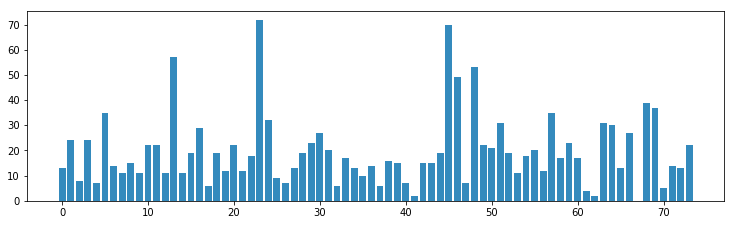

In [3]:
figsize(12.5, 3.5)

count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")


グラフを前半と後半に分ける。その場所をswitch pointと呼ぶ。
$$ \lambda = 	\begin{eqnarray}
\left\{
\begin{array}{l}
\lambda_1 (t < \tau ) \\
\lambda_2 (t \geq \tau )
\end{array}
\right.
\end{eqnarray} $$

$\lambda_1$、1$\lambda_2$を決める。
$$ \lambda_1 \sim Exp(\alpha) $$
$$ \lambda_2 \sim Exp(\alpha) $$
$\alpha$はハイパーパラメータ。指数分布で$\lambda$をモデル化しているので、期待値は平均値の逆数になる。これを使って$\alpha$を決める。$\tau$は、分布が一様分布(uniform distribution)と信じる。
$$
\tau \sim DiscreteUniform(1,70) \Rightarrow P(\tau = k) = \frac {1} {70}
$$
我々が理解する必要があるのは事後確率だ。

In [4]:
import pymc as pm

alpha = 1.0 / count_data.mean()
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [5]:
@pm.deterministic
def lambda_(tau=tau, lamba_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1 
    out[tau:] = lambda_2
    return out
 

In [6]:
ovservation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([ovservation, lambda_1, lambda_2, tau])

In [7]:
mcmc= pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 7.4 sec

(35, 54)

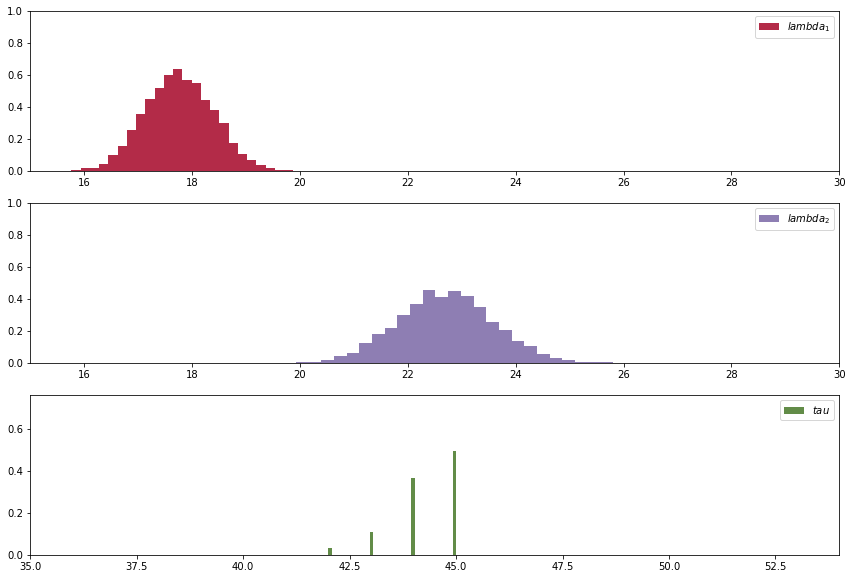

In [8]:
lamba_1_samples = mcmc.trace('lambda_1')[:]
lamba_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

figsize(14.5, 10)

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lamba_1_samples, histtype='stepfilled', bins = 30, alpha=0.85, color = '#A60628', normed=True, label="$lambda_1$")
plt.legend()
plt.xlim([15, 30])

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lamba_2_samples, histtype='stepfilled', bins = 30, alpha=0.85, color = '#7A68A6', normed=True, label="$lambda_2$")
plt.legend()
plt.xlim([15, 30])

ax = plt.subplot(313)
ax.set_autoscaley_on(False)
w = 1.0/tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, histtype='stepfilled', bins = n_count_data, alpha=0.85, color = '#467828', label="$tau$", 
        weights = w, rwidth=2)
plt.legend()
plt.ylim([0, 0.76])
plt.xlim([35, len(count_data) - 20])


